# **Лабораторная работа №3 по вычислительной математикe.**

## Работу выполнил: Шурыгин Антон, Б01 - 909.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## **Исходные данные**

In [136]:
pop_stats = {
    1910 : 92228496,
    1920 : 106021537,
    1930 : 123202624,
    1940 : 132164569,
    1950 : 151325798,
    1960 : 179323175,
    1970 : 203211926,
    1980 : 226545805,
    1990 : 248709873,
    2000 : 281421906,
}

pop_2010 = 308745538
interp_yr = 2010

yr_offset = interp_yr - list(pop_stats.keys())[0]

## **Определим функцию для построения графика населения США**

### Полезные константы для графопостроительной функции

In [137]:

pop_label = "данные переписи населения"
x_label = "год"
y_label = "Численность населения"

x_lim = [1900, 2020]
y_lim = [0, 9e8]
fig_size = [16, 8]

In [125]:
yrs = list(pop_stats.keys())
pop_value = list(pop_stats.values())

def pop_graph(x_interp, y_interp, poly_labl, color = 'r'):

    plt.figure(figsize=fig_size)

    plt.plot(yrs, pop_value, 'o', label=pop_label)

    if len(y_interp) == 1 and len(x_interp) == 1:
        plt.plot(x_interp, y_interp, 'o', label=poly_labl)
        x_interp = yrs + x_interp
        y_interp = pop_value + y_interp

    plt.plot(x_interp, y_interp, color, label=poly_labl)
    
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend()
    plt.show()

## **Построим интерполянт в форме Ньютона**

In [131]:
def get_diff_tb(data):

    x, y = list(data.keys()), list(data.values())
    len_x = len(x)
    assert len_x == len(y)

    diff_tb = np.zeros((len_x, len_x))
    diff_tb[0] = y
    diff_tb = diff_tb.transpose()
    
    for i in range(1, len_x):
        for j in range(0, len_x - i):
            diff_tb[j][i] = (diff_tb[j + 1][i - 1] - diff_tb[j][i-1])\
                                       / (x[i + j] - x[j])
    
    return diff_tb


def newton_poly(x, yrs, diff_tb):

    fst_node = diff_tb[0]
    n = len(yrs)
    poly = fst_node[n - 1]

    for i in range(1, n):
        poly = fst_node[n - i - 1] + poly * (x - yrs[n - i - 1]) 
    
    return poly
    

def newton_interpolation(data, grph_fn):
    diff_tb = get_diff_tb(data)

    yrs = list(data.keys())
    
    x_data = np.arange(yrs[0], yrs[len(yrs) - 1] + 20, 1)
    poly = newton_poly(x_data, yrs, diff_tb)

    grph_fn(x_data, poly, "интерполянт Ньютона")
    return poly

### Определим функции для построения интерполянта Ньютона

## Выведем красиво матрицу с помощью модуля ```pandas```

In [61]:
# Idea was inspired by Tako-San

,0,1,2,3,4,5,6,7,8,9
0,92228496.0,1379304.1,16940.230,-1934.531333,125.106725,-4.150598,0.080565,-0.000756,-0.000008,5.099328e-07
1,106021537.0,1718108.7,-41095.710,3069.737667,-82.423175,0.683327,0.027611,-0.001362,0.000038,0.000000e+00
2,123202624.0,896194.5,50996.420,-227.189333,-48.256825,2.340014,-0.067705,0.001705,0.000000,0.000000e+00
3,132164569.0,1916122.9,44180.740,-2157.462333,68.743867,-1.722268,0.051623,0.000000,0.000000,0.000000e+00
4,151325798.0,2799737.7,-20543.130,592.292333,-17.369554,1.375117,0.000000,0.000000,0.000000,0.000000e+00
5,179323175.0,2388875.1,-2774.360,-102.489833,51.386312,0.000000,0.000000,0.000000,0.000000,0.000000e+00
6,203211926.0,2333387.9,-5849.055,1952.962667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7,226545805.0,2216406.8,52739.825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
8,248709873.0,3271203.3,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
9,281421906.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


### Вызов интерполяции Ньютона

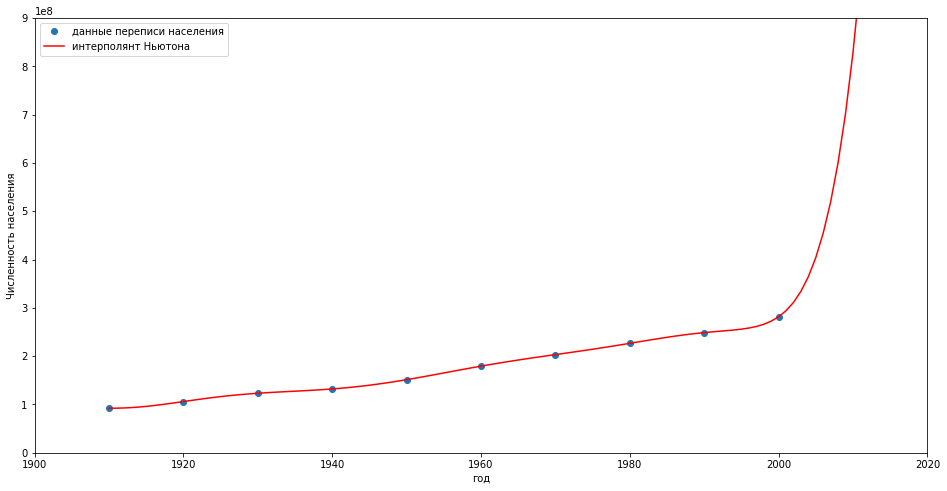

Интерполяция Ньютона
Экстраполированное значение населения: 827906509 человек
Реальное значение населения 308745538 человек


In [140]:
interp_pop = newton_interpolation(pop_stats, pop_graph)

print("Интерполяция Ньютона")
print(f'Экстраполированное значение населения: {int(interp_pop[yr_offset])} человек')
print(f'Реальное значение населения {pop_2010} человек')

## **Построим сплайн-аппроксимацию**

### Определим класс-обертку над кубическим сплайном

In [160]:
class spline:
    def __init__(self, a=0, b=0, c=0, d=0, x=0):

        self.a = a
        self.b = b
        self.c = c
        self.d = d

        self.x = x

## Определим функции для сплайн-интерполяции

- ```spline_interp(data, interp_x, plt_fn)``` - оболочка над всеми служебными функциями
- ```build(data)``` - конструктор массива сплайнов
- ```interpolate(splines, x)``` - функция, интерполирующая заданную величину $x$

In [161]:
def spline_interp(data, interp_x, plt_fn):
    spl_arr = build(data)
    
    try:
        interp_y = interpolate(spl_arr, interp_x) 
    except Exception as err:
        print(err)
    else:
        plt_fn([interp_x], [interp_y], "сплайн-интерполянт", 'b')
        return interp_y


def build(data):
    
    x, y = list(data.keys()), list(data.values())
    len_x = len(x)
    assert len_x == len(y)

    splines = [spline() for _ in range(len_x)]

    for i in range(0, len_x):
        splines[i].x, splines[i].a = x[i], y[i]
    
    splines[0].c = splines[len_x - 1].c = 0.0
    
    # Методом трехдиагональной прогонки находим с[i]
    alpha = [0.0 for _ in range(len_x - 1)]
    beta  = [0.0 for _ in range(len_x - 1)]
 
    for i in range(1, len_x - 1):

        h_i  = x[i] - x[i - 1]
        h_i_1 = x[i + 1] - x[i]

        A, B = h_i, h_i_1
        C = 2.0 * (h_i + h_i_1)
        F = 6.0 * ((y[i + 1] - y[i]) / h_i_1 - (y[i] - y[i - 1]) / h_i)

        z = (A * alpha[i - 1] + C)

        alpha[i] = -B / z
        beta[i] = (F - A * beta[i - 1]) / z
  
    # Нахождение решения - обратный ход метода прогонки
    for i in range(len_x - 2, 0, -1):
        splines[i].c = alpha[i] * splines[i + 1].c + beta[i]
    
    # Определяем  b[i] и d[i]
    for i in range(len_x - 1, 0, -1):
        hi = x[i] - x[i - 1]

        splines[i].d = (splines[i].c - splines[i - 1].c) / hi

        splines[i].b =  (y[i] - y[i - 1]) / hi + \
                  hi * (splines[i].c / 3 + splines[i - 1].c / 6) 
                                    
    return splines
 

def bin_search(arr, len, x):
    i, j = 0, len - 1

    while i + 1 < j:
        k = i + (j - i) // 2
        if x <= arr[k].x:
            j = k
        else:
            i = k

    return arr[j]
 

def interpolate(splines, x):
    if not splines:
        raise Exception("Ошибка : сплайнов не существует")
    
    spl_len = len(splines)
    interp_y = spline()
    
    if x <= splines[0].x:
        interp_y = splines[0]

    elif x >= splines[spl_len - 1].x:
        interp_y = splines[spl_len - 1]

    else:
        interp_y = bin_search(splines, spl_len, x)
    
    dx = x - interp_y.x

    return interp_y.a + (interp_y.b + (interp_y.c / 2.0 + interp_y.d * dx / 6.0) * dx) * dx


### Вызов сплайн-интерполяции

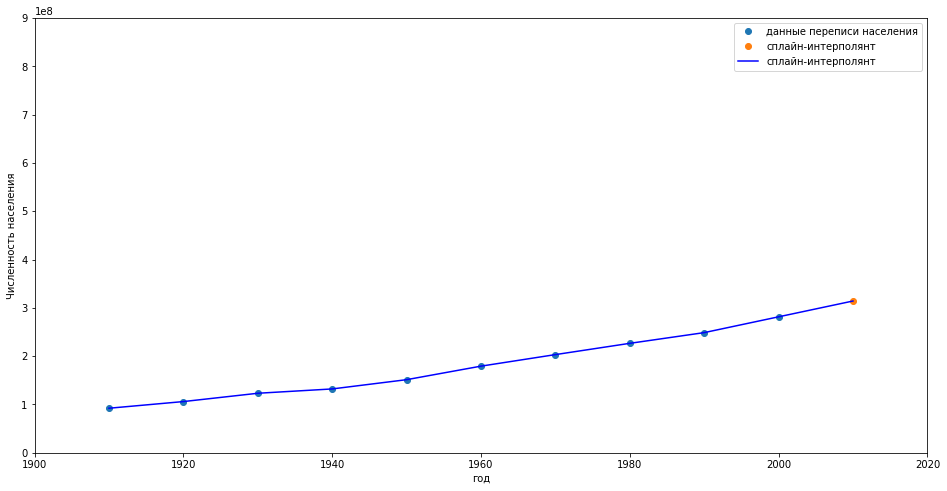

Сплайн-интерполяция
Экстраполированное значение населения : 314133939 человек
Реальное значение населения 308745538 человек


In [162]:
interp_pop = spline_interp(pop_stats, interp_yr, pop_graph)

print("Сплайн-интерполяция")
print(f'Экстраполированное значение населения : {int(interp_pop)} человек')
print(f'Реальное значение населения {pop_2010} человек')

## **Сравним полученные значения с результатами интерполяции из модуля ```scipy```**

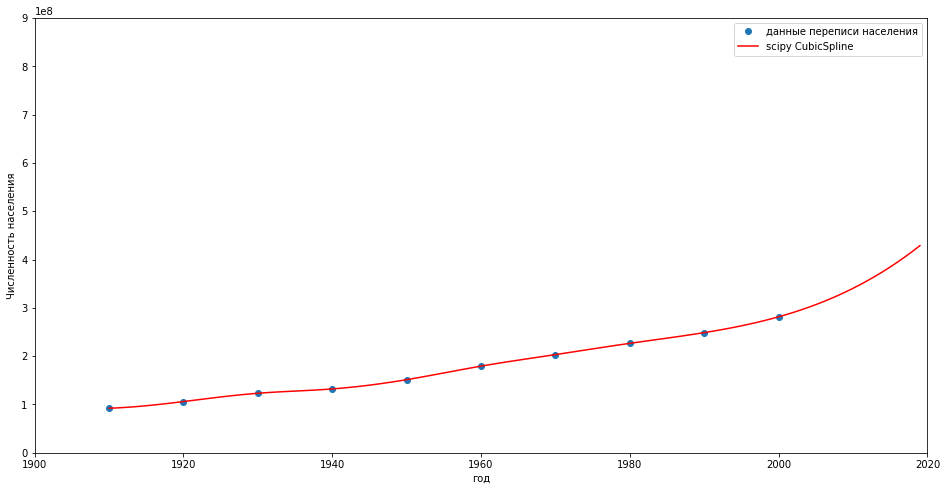

Сплайн-инерполяция библиотеки scipy
Экстраполированное значение населения : 340343089 человек
Реальное значение населения 308745538 человек


In [142]:
from scipy.interpolate import CubicSpline

x, y = list(pop_stats.keys()), list(pop_stats.values())
len_x = len(x)

x_data = np.arange(x[0], x[len_x - 1] + 20, 1)

pop_spline = CubicSpline(x, y)
pop_graph(x_data, pop_spline(x_data), "scipy CubicSpline")

pop_spline(x_data)[yr_offset]

print("Сплайн-инерполяция библиотеки scipy")
print(f'Экстраполированное значение населения : {int(pop_spline(x_data)[yr_offset])} человек')
print(f'Реальное значение населения {pop_2010} человек')